# SVM for Lyrics Genre Classification

Text classification is the task of sorting text documents into predefined classes. 

**Model:**
* The model used bla bla...

## Data set

We start by loading these files into two separate data frames.

In [3]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Loading data to a pandas dataframe
with zipfile.ZipFile('data/spotify_songs.csv.zip') as zip:
    with zip.open('spotify_songs.csv') as myZip:
        data = pd.read_csv(myZip) 

The dataframe contains two columns:
* text: string. Song lyrics.
* label: numeric. Music genre.

In [4]:
from helper_functions import preprocess_lyrics
df = preprocess_lyrics(data)
df.head()

,text,label
1,"The trees, are singing in the wind The sky blu...",0
2,"NA Yeah, Spyderman and Freeze in full effect U...",1
3,I really can't stay Baby it's cold outside I'v...,1
4,Get up out of my business You don't keep me fr...,2
5,"Hold your breath, don't look down, keep trying...",1


## Visualization

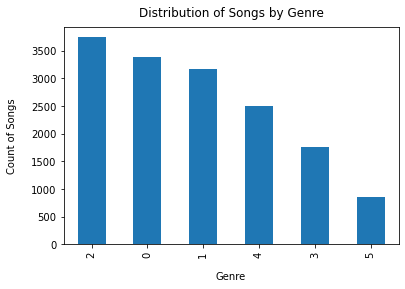

In [5]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.xlabel("Genre", labelpad=14)
plt.ylabel("Count of Songs", labelpad=14)
plt.title("Distribution of Songs by Genre", y=1.02)
plt.show()

In [6]:
# Split train and test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'])

# Split train and validation
print(df.shape)
print(train_df.shape)
print(test_df.shape)

(15405, 2)
(12324, 2)
(3081, 2)


## Train Model

### Baseline models

In [7]:
# Train model
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

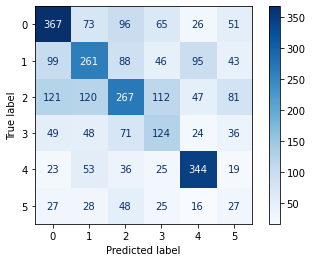

In [8]:
# SVM with Counter Words Vector representation - Default values

# Pipeline
pipe = Pipeline(steps=[('preprocessor', CountVectorizer(stop_words='english')),
                       ('model', SGDClassifier(max_iter=1000,
                                               class_weight='balanced'))])

# Fit model
fit_pipe = pipe.fit(train_df['text'], train_df['label'])

# Plot Confusion Matrix
plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()

In [9]:
# Predictions
preds = fit_pipe.predict(test_df['text'])

print(classification_report(test_df['label'], preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.53      0.54      0.54       678
           1       0.45      0.41      0.43       632
           2       0.44      0.36      0.39       748
           3       0.31      0.35      0.33       352
           4       0.62      0.69      0.65       500
           5       0.11      0.16      0.13       171

    accuracy                           0.45      3081
   macro avg       0.41      0.42      0.41      3081
weighted avg       0.46      0.45      0.45      3081



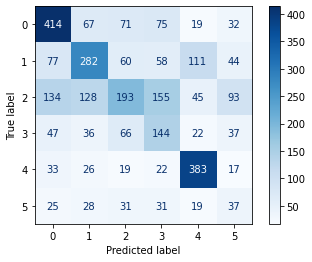

In [10]:
# SVM with TF-IDF representation - Default values kind of thing

from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline
pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer(stop_words='english')),
                       ('model', SGDClassifier(max_iter=1000,
                                               class_weight='balanced'))])

# Fit model
fit_pipe = pipe.fit(train_df['text'], train_df['label'])

# Plot confusion matrix
plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()

In [11]:
# Predictions
preds = fit_pipe.predict(test_df['text'])

print(classification_report(test_df['label'], preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.57      0.61      0.59       678
           1       0.50      0.45      0.47       632
           2       0.44      0.26      0.32       748
           3       0.30      0.41      0.34       352
           4       0.64      0.77      0.70       500
           5       0.14      0.22      0.17       171

    accuracy                           0.47      3081
   macro avg       0.43      0.45      0.43      3081
weighted avg       0.48      0.47      0.47      3081



**Result:** 
* The model with the TF-IDF vector representation yielded better results that the one with the Counter vector representation. From this point, the former will be used.

### Grid Search

# SVM with TF-IDF representation Vector representation

from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer(stop_words='english')),
                       ('model', SGDClassifier(max_iter=1000,
                                               class_weight='balanced',
                                               n_jobs=-1,
                                               eta0=0.1))])


# Hyperparameters values
parameters = {'preprocessor__binary':[True, False],
              'preprocessor__ngram_range':((1,2),(2,2)),
              'model__penalty': ('l2','elasticnet'),
              'model__learning_rate': ('optimal','adaptive')
              'model__solver': ('newton-cg', 'saga')}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1)

gs_fit = grid_search.fit(train_df['text'], train_df['label'])

best_parameters = grid_search.best_estimator_.get_params()

print("Best parameters set:")
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

**Best parameters:**
* model_learning_rate: 'adaptive'
* model_penalty: 'l2'
* preprocessor_binary: True
* preprocessor_ngram_range: (1,2)
* time: 794s

### Fine-tuned Models

#### Logistic Regression with TF-IDF Vector representation

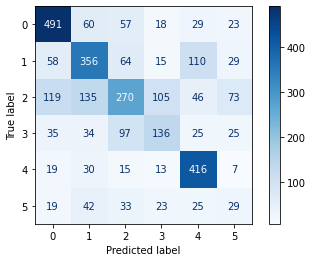

In [12]:
# SVM with TF-IDF Vector - Fine-tuned values

# Pipeline
pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer(stop_words='english',
                                                        binary=True,
                                                        ngram_range=(1,2))),
                       ('model', SGDClassifier(max_iter=1000,
                                               class_weight='balanced',
                                               learning_rate='adaptive',
                                               penalty='l2',
                                               n_jobs=-1,
                                               eta0=0.1))])

# Fit model
fit_pipe = pipe.fit(train_df['text'], train_df['label'])

# Plot Confusion Matrix
plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()

In [13]:
# Predictions
preds = fit_pipe.predict(test_df['text'])

print(classification_report(test_df['label'], preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       678
           1       0.54      0.56      0.55       632
           2       0.50      0.36      0.42       748
           3       0.44      0.39      0.41       352
           4       0.64      0.83      0.72       500
           5       0.16      0.17      0.16       171

    accuracy                           0.55      3081
   macro avg       0.49      0.51      0.49      3081
weighted avg       0.54      0.55      0.54      3081



**Result:**
* With the fine tuned parameters the overall accuracy of the model improved 5 points.

## Creating a balanced data set

The distribution of the 6 different music genres (classes) is imbalanced. Therefore, **undersampling** is used, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

In [14]:
# Number of observations of the smallest class
n_min = min(train_df['label'].value_counts())

# Sample n_min observations of each class
balanced = train_df.groupby('label').apply(lambda x: x.sample(n=n_min, replace=False))

print(balanced.shape)

(4116, 2)


#### LR with TF-IDF / fine-tuned / balanced

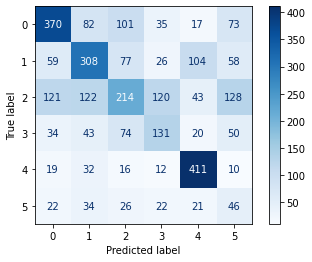

In [15]:
# SVM with TF-IDF Vector - Fine-tuned values

# Pipeline
pipe = Pipeline(steps=[('preprocessor', TfidfVectorizer(stop_words='english',
                                                        binary=True,
                                                        ngram_range=(1,2))),
                       ('model', SGDClassifier(max_iter=1000,
                                               class_weight='balanced',
                                               learning_rate='adaptive',
                                               penalty='l2',
                                               n_jobs=-1,
                                               eta0=0.1))])

# Fit model
fit_pipe = pipe.fit(balanced['text'], balanced['label'])

# Plot confusion matrix
plot_confusion_matrix(fit_pipe, test_df['text'], test_df['label'], cmap=plt.cm.Blues)

plt.show()

In [16]:
# Predictions
preds = fit_pipe.predict(test_df['text'])

print(classification_report(test_df['label'], preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57       678
           1       0.50      0.49      0.49       632
           2       0.42      0.29      0.34       748
           3       0.38      0.37      0.38       352
           4       0.67      0.82      0.74       500
           5       0.13      0.27      0.17       171

    accuracy                           0.48      3081
   macro avg       0.45      0.46      0.45      3081
weighted avg       0.49      0.48      0.48      3081



**Results:**
- With the balanced dataset the results is worse. This is due the amount of data is very small and to train the model properly it is necessary more data. 

## Final Results

The optimal model chosen is the SVM with a TF-IDF representation trained on all the imbalanced dataset. The results obtained are:

In [17]:
# Optimal model
